In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import ndimage
from datetime import datetime

In [2]:
def set_white_color(original_cmap):
    # Get the colors from the original colormap
    clrs = original_cmap(np.linspace(0, 1, original_cmap.N))
    # Set the first color to white
    clrs[0, :] = [1, 1, 1, 1] #RGBA values for white
    # Create a new colormap
    new_cmap = colors.ListedColormap(clrs)
    return(new_cmap)


def array_to_xarray(array,xarray):
    """
    scipy.ndimage converts xarray to array, this function reverts it back to xarray
    """
    new_xarray = xr.DataArray(
        array,
        dims=xarray.dims,  
        coords=xarray.coords,  
        attrs=xarray.attrs,
    )
    return new_xarray

def label_clusters(data_array, structure=None):
    """
    Defines clusters in data_array and labels it. Structure can be given to change how ndimage clusters points together.
    """
    labeled_array, num_features = ndimage.label(data_array.values, structure=structure) #num_features is ignored
    labeled_xarray = array_to_xarray(labeled_array,data_array)
    return labeled_xarray

def area_weights(data_array,latitude_dim_name='latitude',R = 6371):
    """
    Area of one grid cell (assuming spatial resolution is 0.25 x 0.25)
    """
    #R = 6371 km^2
    return (R**2)*np.deg2rad(0.25)*np.deg2rad(0.25)*np.cos(np.deg2rad(data_array[latitude_dim_name]))#np.cos(data_array[latitude_dim_name]*np.pi/180)

def filter_clusters_by_area(data_array,latitude_dim_name='latitude',AREA_THRESHOLD=500):
    ds_temp = xr.Dataset({'labels': data_array})
    ds_temp['area'] = area_weights(data_array,latitude_dim_name=latitude_dim_name)    
    label_areas= ds_temp.groupby('labels').sum() 
    labels_to_keep = label_areas.where(label_areas>AREA_THRESHOLD,drop=True)
    labels_to_keep = labels_to_keep['labels'].values
    labels_to_keep = labels_to_keep[labels_to_keep>0]
    if len(labels_to_keep) == 0:
        data_array[:] = 0
    else:
        data_array = data_array.isin(labels_to_keep).astype(int)
    return data_array

def label_and_filter(ds,mask_dim='mask',area_dim='areas',AREA_THRESHOLD=500000):
    ds['labeled_clusters'] = label_clusters(ds[mask_dim])
    cluster_areas = ds[[area_dim,'labeled_clusters']].groupby(['labeled_clusters']).sum()
    cluster_areas[area_dim][0] = 0
    cluster_selection = np.unique(cluster_areas["labeled_clusters"].where(cluster_areas[area_dim]>AREA_THRESHOLD).values)
    ds['labeled_clusters_filtered'] = ds['labeled_clusters']*ds['labeled_clusters'].isin(cluster_selection)
    return(ds)

def apply_binary_morph(data_array,s=np.ones((3,3)),method='dilation'):
    """
    Apply binary structure (s) to data_array using one of the methods available ['dilation','erosion','closing','fill_holes']
    data_array and s must have the same number of dimensions
    """
    if len(data_array.shape) != len(s.shape):
        print("No morphology change: data array and structure have different shapes")
        return(data_array)
    if method not in ['dilation','erosion','closing','fill_holes']:
        print("No morphology change: methods needs to be one of ['dilation','erosion','closing','fill_holes']")
        return(data_array)
    if method=='dilation':
        binary_transformation = ndimage.binary_dilation(data_array,structure=s).astype(int)
    elif method =='erosion':
        binary_transformation = ndimage.binary_erosion(data_array,structure=s).astype(int)
    elif method == 'closing':
        binary_transformation = ndimage.binary_closing(data_array,structure=s).astype(int)
    elif method == 'fill_holes':
        binary_transformation = ndimage.binary_fill_holes(data_array,structure=s).astype(int)
    return array_to_xarray(array=binary_transformation,xarray=data_array)

In [3]:
#PARAMETERS
STDEV_THRESHOLD = -1.5
SMALL_BLOBS_FILTER = 50
AREA_THRESHOLD=500000#in km^2
VARIABLE = 'anomaly_scaled'
cmap_stdev = colors.LinearSegmentedColormap.from_list("", ["purple","darkblue","blue","lightblue","white","lightcoral","red","darkred","pink"])
z = [-3,-2,-1.5,-1,-0.5,0.5,1,1.5,2,3]
norm = colors.TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))
new_cmap_viridis = set_white_color(plt.cm.viridis)
new_cmap_set1 = set_white_color(plt.cm.Set1)

In [4]:
ds = xr.open_dataset("temp/era5_t2min_scaled_anomalies.nc")

In [5]:
ds

<xarray.Dataset> Size: 46MB
Dimensions:         (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude        (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time            (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min    (time, latitude, longitude) float32 15MB ...
    anomaly         (time, latitude, longitude) float32 15MB ...
    anomaly_scaled  (time, latitude, longitude) float32 15MB ...

## mask by stdev threshold

In [6]:
ds["mask"] = ds[VARIABLE] <= STDEV_THRESHOLD

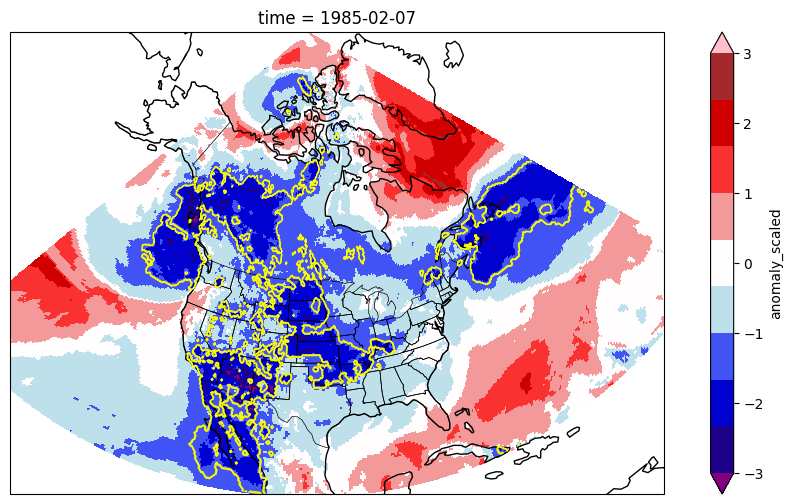

In [7]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['anomaly_scaled'].plot(transform=ccrs.PlateCarree(),cmap=cmap_stdev,norm=norm,levels=z,extend="both")
ds.sel(time='1985-02-07')['mask'].plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.5)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

Yellow contours highlighting clusters where scaled anomalies < -1.5C

## Label clusters

In [8]:
#ds["labeled_clusters"] = ds['mask'].groupby('time').map(label_clusters)

## Filter smaller clusters by area

In [9]:
grid_areas = area_weights(ds['mask'])
ds['areas'] = grid_areas.broadcast_like(ds.isel(time=1))
ds = ds.groupby('time').map(label_and_filter)

c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labeled_clusters because variable labeled_clusters is not a coordinate. To create an index for labeled_clusters, please first call `.set_coords('labeled_clusters')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labeled_clusters because variable labeled_clusters is not a coordinate. To create an index for labeled_clusters, please first call `.set_coords('labeled_clusters')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labeled_clusters because variable labeled_clusters is not a coordinate. To create an i

#### Scaled anomaly

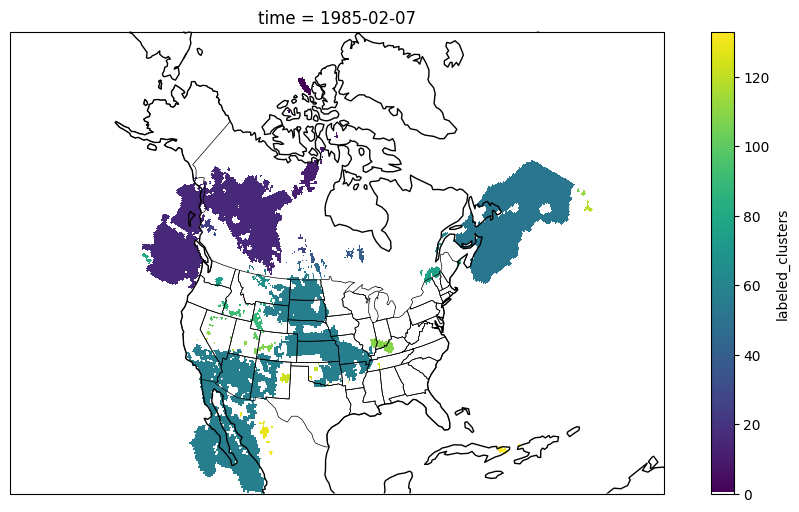

In [10]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_clusters'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

#### Filtered

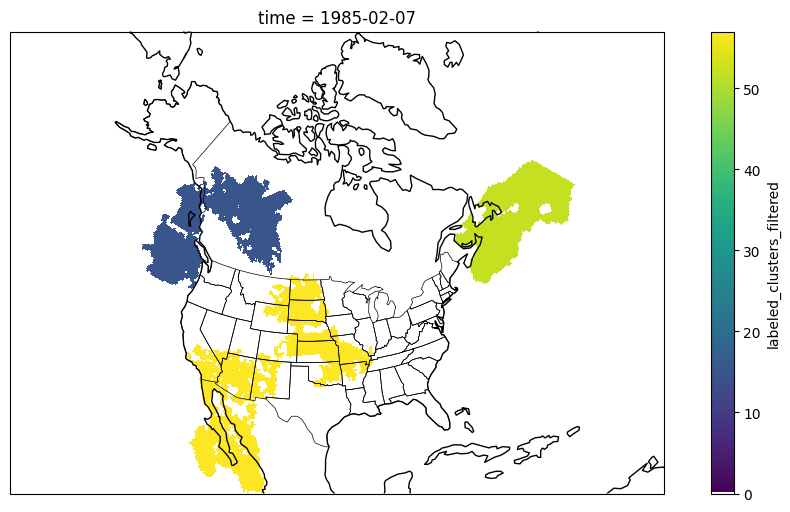

In [11]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_clusters_filtered'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

In [12]:
#temp=ds[['labeled_clusters','area']].groupby(('time','labeled_clusters')).sum()
#temp['area'].to_pandas()

## Deforming clusters using binary masks

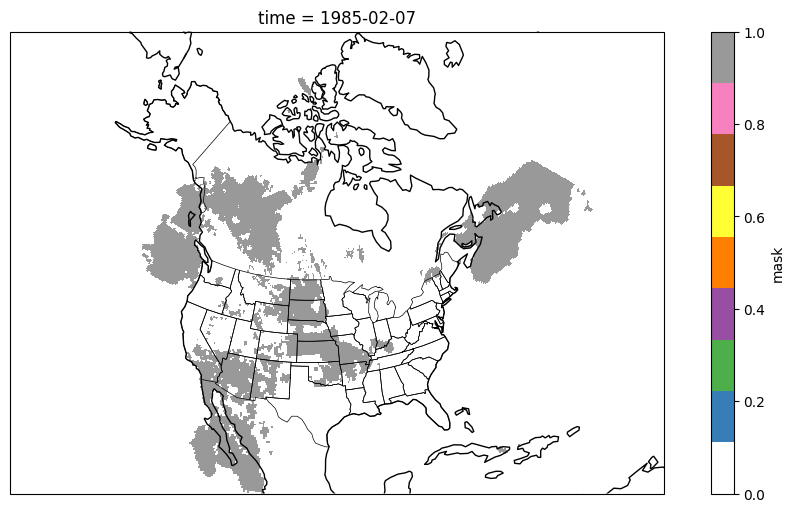

In [13]:
#Original
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds["mask"].sel(time='1985-02-07').plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

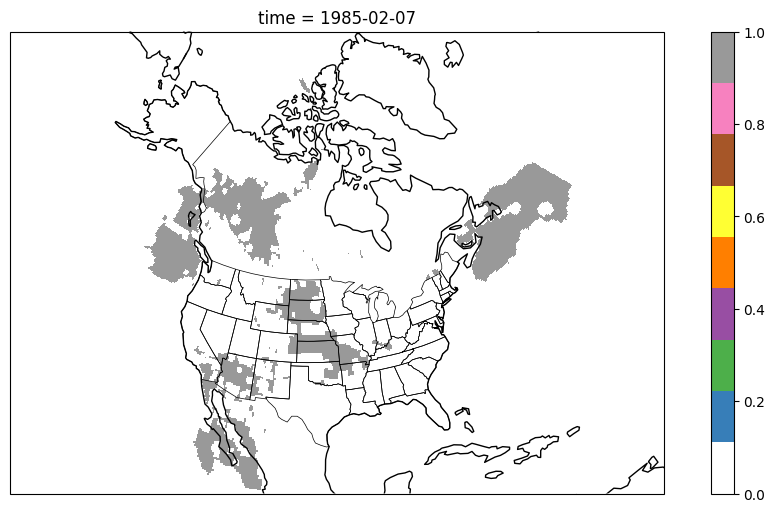

In [14]:
#Erosion
a=apply_binary_morph(ds["mask"].sel(time='1985-02-07'),method='erosion',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

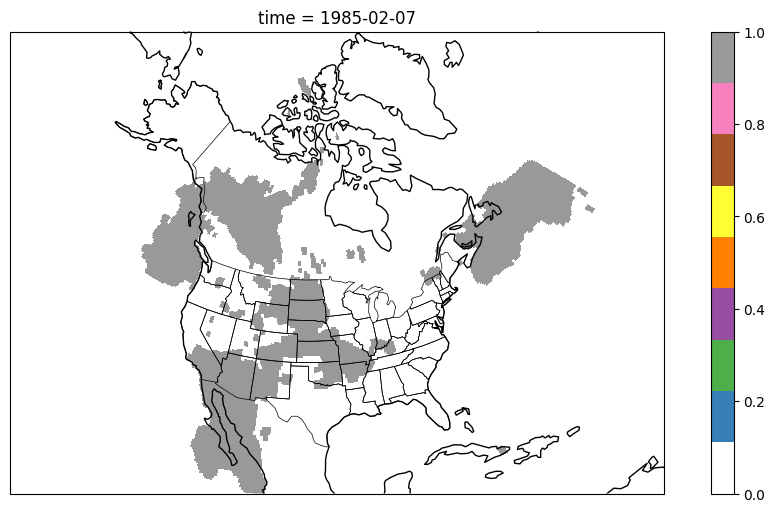

In [15]:
#Sequence of deformations
a = ds["mask"].sel(time='1985-02-07')
a=apply_binary_morph(a,method='closing',s=np.ones((3,3)))
a=apply_binary_morph(a,method='erosion',s=np.ones((2,2)))
a=apply_binary_morph(a,method='dilation',s=np.ones((3,3)))
a=apply_binary_morph(a,method='fill_holes',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Area filtering

In [16]:
ds

<xarray.Dataset> Size: 111MB
Dimensions:                    (time: 31, latitude: 281, longitude: 441)
Coordinates:
  * latitude                   (latitude) float32 1kB 90.0 89.75 ... 20.25 20.0
  * longitude                  (longitude) float32 2kB -150.0 -149.8 ... -40.0
  * time                       (time) datetime64[ns] 248B 1970-02-07 ... 2000...
Data variables:
    daily_t2_min               (time, latitude, longitude) float32 15MB 243.4...
    anomaly                    (time, latitude, longitude) float32 15MB -0.90...
    anomaly_scaled             (time, latitude, longitude) float32 15MB -0.15...
    mask                       (time, latitude, longitude) bool 4MB False ......
    areas                      (time, latitude, longitude) float64 31MB -3.37...
    labeled_clusters           (time, latitude, longitude) int32 15MB 0 0 ... 0
    labeled_clusters_filtered  (time, latitude, longitude) int32 15MB 0 0 ... 0

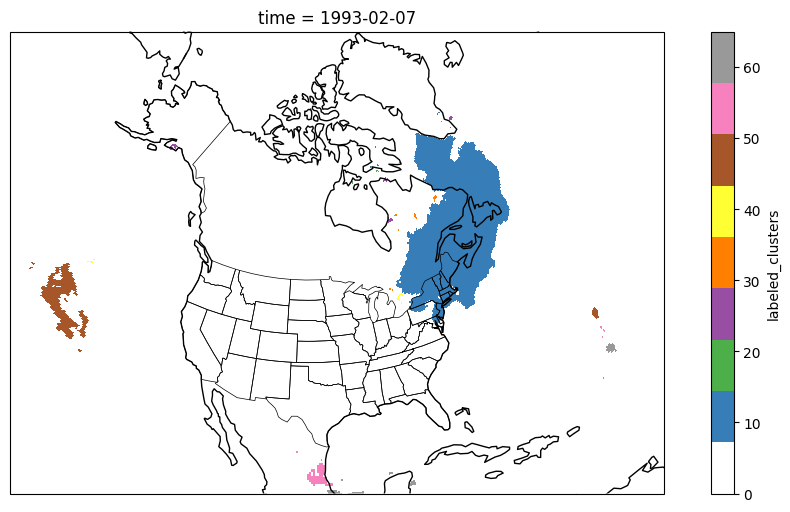

In [17]:
data_array = ds["labeled_clusters"].sel(time='1993-02-07')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
data_array.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

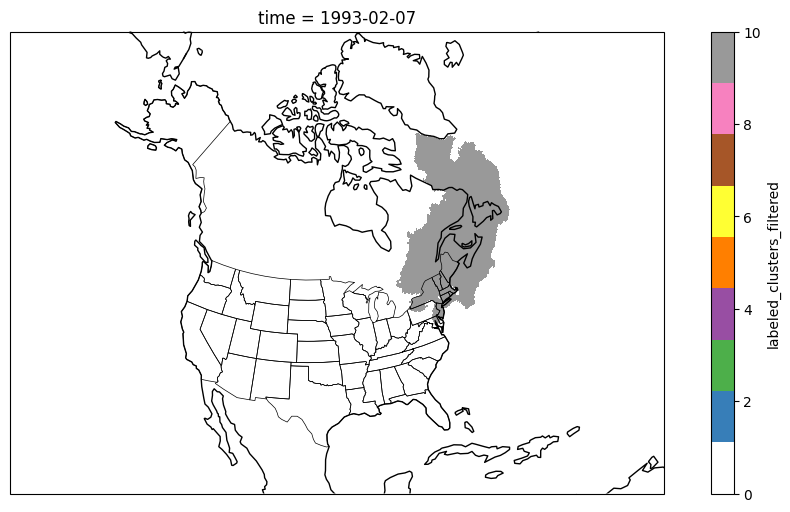

In [18]:
data_array = ds["labeled_clusters_filtered"].sel(time='1993-02-07')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
data_array.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Area coverage

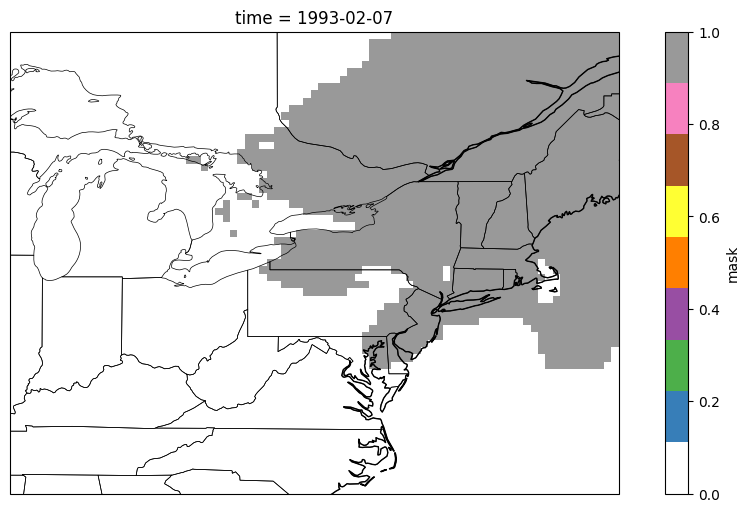

In [19]:
data_set = ds.sel(time='1993-02-07')
data_set = data_set.sel(latitude=slice(50, 34.5), longitude=slice(-88.5, -68))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['mask'].plot(cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

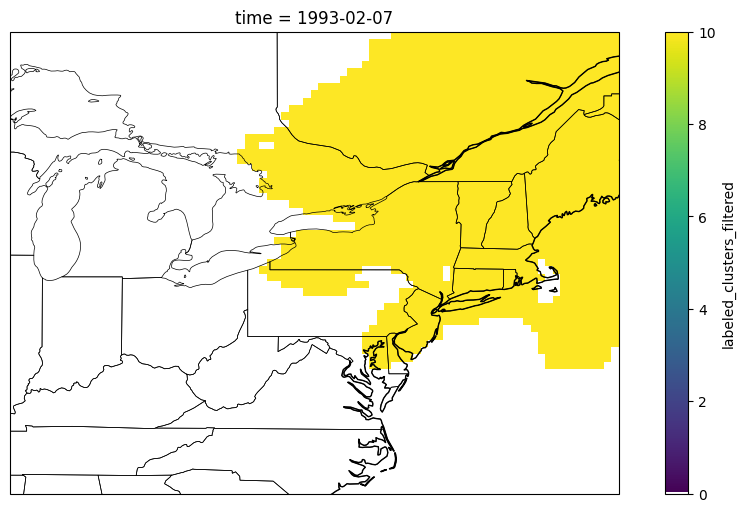

In [20]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['labeled_clusters_filtered'].plot(cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

In [21]:
#Total domain area
grid_areas = area_weights(data_set['mask'])
data_set['areas'] = grid_areas.broadcast_like(data_set)
total_area = data_set['areas'] .sum()
data_set['areas_weight'] = data_set['areas']/total_area

In [22]:
grid_areas = area_weights(ds['mask'])
grid_areas.broadcast_like(ds.isel(time=1))

<xarray.DataArray 'latitude' (latitude: 281, longitude: 441)> Size: 991kB
array([[-3.37788269e-05, -3.37788269e-05, -3.37788269e-05, ...,
        -3.37788269e-05, -3.37788269e-05, -3.37788269e-05],
       [ 3.37187136e+00,  3.37187136e+00,  3.37187136e+00, ...,
         3.37187136e+00,  3.37187136e+00,  3.37187136e+00],
       [ 6.74362036e+00,  6.74362036e+00,  6.74362036e+00, ...,
         6.74362036e+00,  6.74362036e+00,  6.74362036e+00],
       ...,
       [ 7.23831699e+02,  7.23831699e+02,  7.23831699e+02, ...,
         7.23831699e+02,  7.23831699e+02,  7.23831699e+02],
       [ 7.25005647e+02,  7.25005647e+02,  7.25005647e+02, ...,
         7.25005647e+02,  7.25005647e+02,  7.25005647e+02],
       [ 7.26165776e+02,  7.26165776e+02,  7.26165776e+02, ...,
         7.26165776e+02,  7.26165776e+02,  7.26165776e+02]],
      shape=(281, 441))
Coordinates:
  * latitude   (latitude) float32 1kB 90.0 89.75 89.5 89.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float32 2kB -150.0 -149.8 -149.5 ... -40.25 -40.0
Attributes:
    long_name:  latitude
    units:      degrees_north

In [23]:
data_set

<xarray.Dataset> Size: 194kB
Dimensions:                    (latitude: 63, longitude: 83)
Coordinates:
  * latitude                   (latitude) float32 252B 50.0 49.75 ... 34.75 34.5
  * longitude                  (longitude) float32 332B -88.5 -88.25 ... -68.0
    time                       datetime64[ns] 8B 1993-02-07
Data variables:
    daily_t2_min               (latitude, longitude) float32 21kB 252.6 ... 2...
    anomaly                    (latitude, longitude) float32 21kB -1.81 ... 0...
    anomaly_scaled             (latitude, longitude) float32 21kB -0.2834 ......
    mask                       (latitude, longitude) bool 5kB False ... False
    areas                      (latitude, longitude) float64 42kB 496.7 ... 6...
    labeled_clusters           (latitude, longitude) int32 21kB 0 0 0 ... 0 0 0
    labeled_clusters_filtered  (latitude, longitude) int32 21kB 0 0 0 ... 0 0 0
    areas_weight               (latitude, longitude) float64 42kB 0.0001666 ....

total area under CAO 

In [24]:
data_set.groupby('labeled_clusters_filtered').sum()['areas']

c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labeled_clusters_filtered because variable labeled_clusters_filtered is not a coordinate. To create an index for labeled_clusters_filtered, please first call `.set_coords('labeled_clusters_filtered')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


<xarray.DataArray 'areas' (labeled_clusters_filtered: 2)> Size: 16B
array([2012350.0116319 ,  969325.79603039])
Coordinates:
    time                       datetime64[ns] 8B 1993-02-07
  * labeled_clusters_filtered  (labeled_clusters_filtered) int32 8B 0 10
Attributes:
    long_name:  latitude
    units:      degrees_north

total area where scaled anomaly is less than -1.5C

In [25]:
(data_set['mask'].astype(int) * data_set['areas']).sum()

<xarray.DataArray ()> Size: 8B
array(975388.17996218)
Coordinates:
    time     datetime64[ns] 8B 1993-02-07

## Gaussian filter

In [26]:
def gaussian_filter(data_set,center_lon,center_lat,b=0.05,lat_dim_name="latitude",lon_dim_name="longitude"):
    
    X=data_set[lon_dim_name].broadcast_like(data_set)
    Y=data_set[lat_dim_name].broadcast_like(data_set)
    G = 1/(2*np.pi*b**2) * np.exp(-((np.deg2rad(Y)-np.deg2rad(center_lat))**2 + (np.deg2rad(X)-np.deg2rad(center_lon))**2)/(2*b**2))
    return(G)

In [27]:
data_set["G"] = gaussian_filter(data_set=data_set,center_lon = -75.6,center_lat = 42.9,b=0.18)
data_set['G']  = data_set['G']/np.max(data_set['G'])

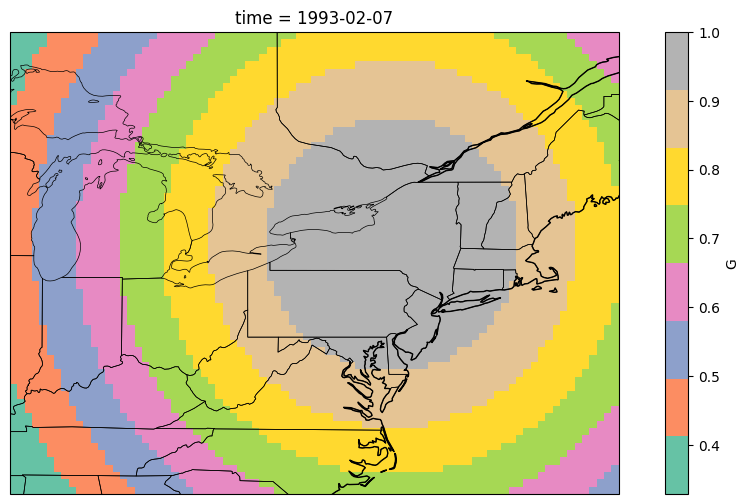

In [28]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['G'].plot(cmap='Set2')
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

## Area coverage using different filters

In [29]:
#Coverage by number of points
total_points = np.size(data_set.latitude) * np.size(data_set.longitude)
(np.sum(data_set['mask'])/total_points).values

array(0.34079174)

In [30]:
#Coverage weighted by area
total_area = np.sum(data_set['areas'])
(np.sum((data_set['areas']*data_set['mask']))/total_area).values

array(0.32712751)

In [31]:
#Coverage weighted by gaussian
total_gaussian = np.sum(data_set.G)
(np.sum((data_set['G']*data_set['mask']))/total_gaussian).values

array(0.39423901)